# Product Pricing Chart Case Study
## Product Price Optimization

- Product A has a raw material cost of around \$7 and takes about 30 - 45 minutes of processing time to complete.
- Product starts at 35 dollars and vendor is charging 5 dollars for each additional color used in construction.


In [69]:
# products start at $35 and cost $5 extra for each additional color
import numpy as np
from seaborn import boxenplot

# Define constants
BASE_PRICE = 40
DEFAULT_LENGTH = 12
DEFAULT_WIDTH = 8
MATERIAL_LOSS = 8
MATERIAL_PRICE_LIST = [14.94 / 2, 34.09 / 4, 48.60 / 10, 19.11 / 4]
MATERIAL_PRICE = np.mean(MATERIAL_PRICE_LIST)
print(f"MATERIAL_PRICE: ${MATERIAL_PRICE.round(2)}")

MATERIAL_PRICE: $6.41


### Generating Test Data for analysis
- Product has 3 parameters which can be customized for each user basis. Length, Weight, and Color.
- In my generated test data I am maxing out on a length of 20 inches.

In [70]:
# Generating test data
import pandas as pd

INCHES_PER_UNIT = 15 * 12
MAX_WIDTH = 12
MAX_LENGTH = 16
MAX_NUM_COLORS = 6
width_list = list(range(6, MAX_WIDTH + 1))
length_list = list(range(6, MAX_LENGTH + 1))
color_list = list(range(1,MAX_NUM_COLORS + 1))
data = []

for color in color_list:
    for width in width_list:
        for length in length_list:
            # Removing invalid params from dataset
            if color < width:
                data.append([length, width, color])

# Order of columns changed
df = pd.DataFrame(columns=['length', 'width', 'num_colors'], data=data)

df.head()

,length,width,num_colors
0,6,6,1
1,7,6,1
2,8,6,1
3,9,6,1
4,10,6,1


In [71]:
# Adding building stats to df
generated_columns = ['get_segment_length', 'get_num_segments', 'get_num_units_raw']
df_build_stats = df.copy()
df_build_stats['get_segment_length'] = df['length'] + 8
df_build_stats['get_num_segments'] = df['width'] / 2
df_build_stats['get_segments_per_color'] = df_build_stats['get_num_segments'] / df['num_colors']
df_build_stats['get_total_length'] = df_build_stats['get_segment_length'] * df_build_stats['get_num_segments']
df_build_stats['get_num_units_raw'] = df_build_stats['get_total_length'] / INCHES_PER_UNIT
df_build_stats['get_length_per_color'] = df_build_stats['get_segment_length'] * df_build_stats['get_num_segments']


#### Segment Length vs Material Count

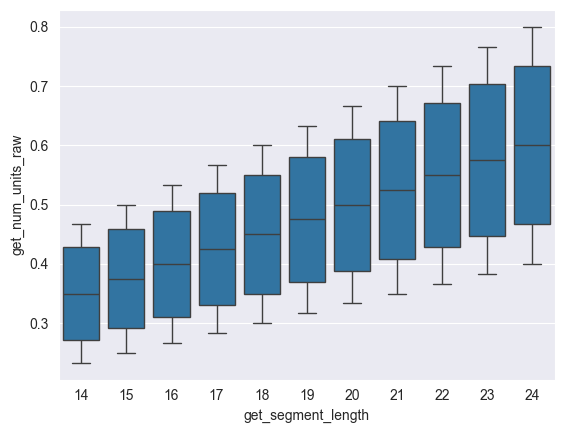

In [72]:
import seaborn as sns
sns.boxplot(data=df_build_stats, x='get_segment_length', y='get_num_units_raw');

Lowest Profit:  16.6
Highest Profit:  58.28
Mean Profit:  41.09
Mean Material Loss:  0.73
Median Profit:  46.09
Hourly Profit:  91.3
Mean Material Loss:  0.73


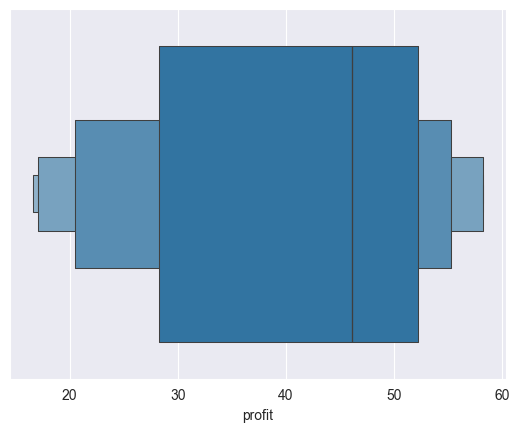

In [73]:
# Check if there is a profit margin in the worst case scenarios.
df_price = df.copy()
COST_PER_UNIT = (15 / 2) + MATERIAL_PRICE  #Two units per order plus shipping and handling
PROCESS_TIME_PER_ORDER = .45
COST_PER_COLOR = 10
df_price['price'] = BASE_PRICE + df_price['num_colors'] * COST_PER_COLOR
df_price['num_units'] = df_build_stats['get_num_units_raw'].round(1) * df_build_stats['num_colors']
df_price['num_units_rounded'] = np.ceil(df_build_stats['get_num_units_raw'] * 2)/2 * df_build_stats['num_colors']
df_price['material_loss'] = df_price['num_units_rounded'] - df_price['num_units']
df_price['material_length'] = df_build_stats['get_segment_length'] * df_build_stats['get_num_segments']
df_price['material_cost']= df_price['num_units_rounded'] * COST_PER_UNIT
df_price['profit']= df_price['price'] - df_price['material_cost']
# Making copy of data for backup
df_price1 = df_price.copy()
meanProfit = df_price.profit.mean()
print("Lowest Profit: ",df_price.profit.min().round(1))
print("Highest Profit: ",df_price.profit.max().round(2))
print("Mean Profit: ",df_price.profit.mean().round(2))
print("Mean Material Loss: ",df_price.material_loss.mean().round(2))
print("Median Profit: ",df_price.profit.median().round(2))
print("Hourly Profit: ", (df_price.profit.mean() / PROCESS_TIME_PER_ORDER).round(2))
print("Mean Material Loss: ",df_price.material_loss.mean().round(2))
profit_columns = ['profit', 'material_loss', 'material_length', 'price', 'material_cost']
sns.boxenplot(data=df_price[profit_columns], x='profit');

### Observations
- The majority or the orders have a profit value between 40 and 60
## Suggestions
- Client should have a base price of at least 40.
- Client should have a per color surcharge of at least 10.

## Material Loss Optimization


### Mean Material Loss

Material Loss: [0.0 to 3.0]
Material Loss Mean:  0.73


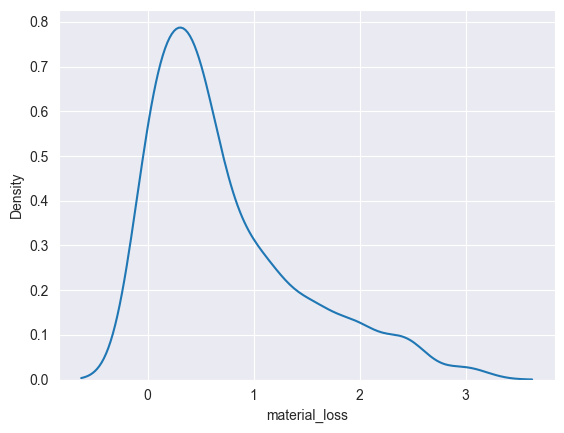

In [86]:
sns.kdeplot(data=df_price, x='material_loss')
print(f"Material Loss: [{df_price['material_loss'].min()} to {df_price['material_loss'].max()}]")
print("Material Loss Mean: ",df_price['material_loss'].mean().round(2))
# The mean material loss

#### Observations
- Most of the orders have a fairly low material_loss value
- The negative values for material loss are a artifact of the seaborn kde function.

### Num Colors vs. Profit

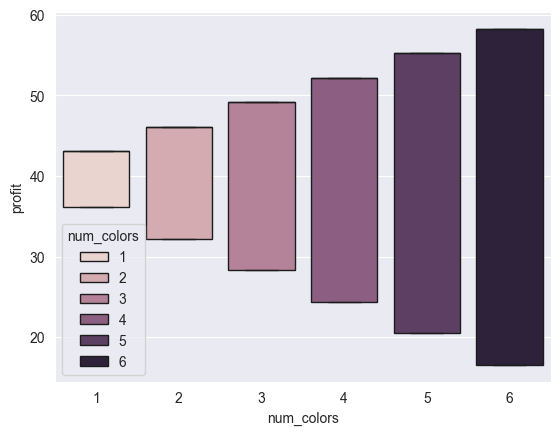

In [75]:
sns.boxplot(data=df_price, x='num_colors', y='profit', hue='num_colors');

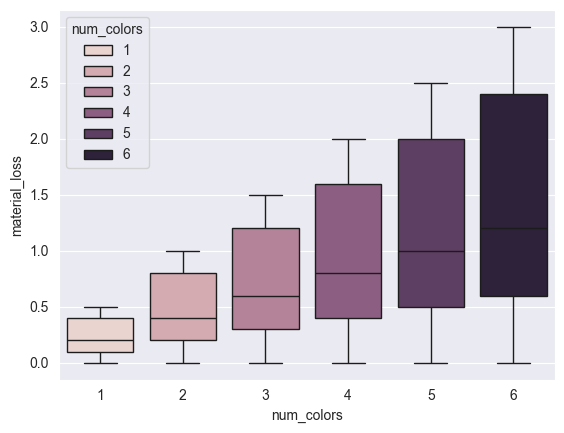

In [76]:
sns.boxplot(data=df_price, x='num_colors', y='material_loss', hue='num_colors');

#### Observations
- Orders with a large number of colors have high variability in their profit margin.
- As num_colors goes up material_loss goes up, but it doesn't go up uniformly across all orders.
#### Suggestions
- If we can figure out what orders have a low material loss values profit could be increased significantly.


### Material Loss vs. Profit

<Axes: xlabel='material_loss', ylabel='profit'>

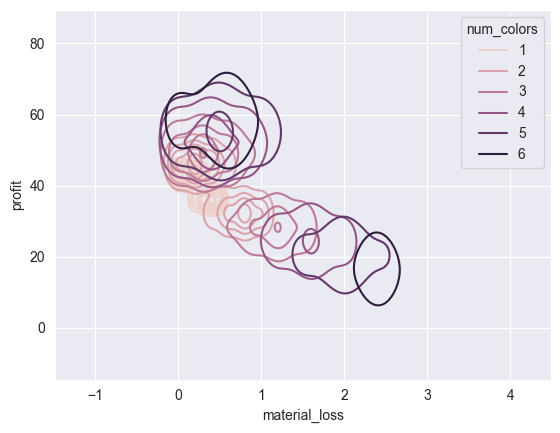

In [85]:
sns.kdeplot(data=df_price, x='material_loss', y='profit', hue='num_colors')


#### Observations
- Orders with high material loss have lower average profit.
- Two trend lines can be seen on this chart one for orders with a high material loss and one for orders with a low value.
- Because we have a surcharge for orders with multiple colors we can still make a profit even on orders with a high material loss.
   - Projects with multiple colors will have a small amount of scrap material in each color so the calculated material loss value may be off.
   - Scrap from one product could be used in future projects which is something these charts are unable to account for.

### Material Loss Scatter Plots

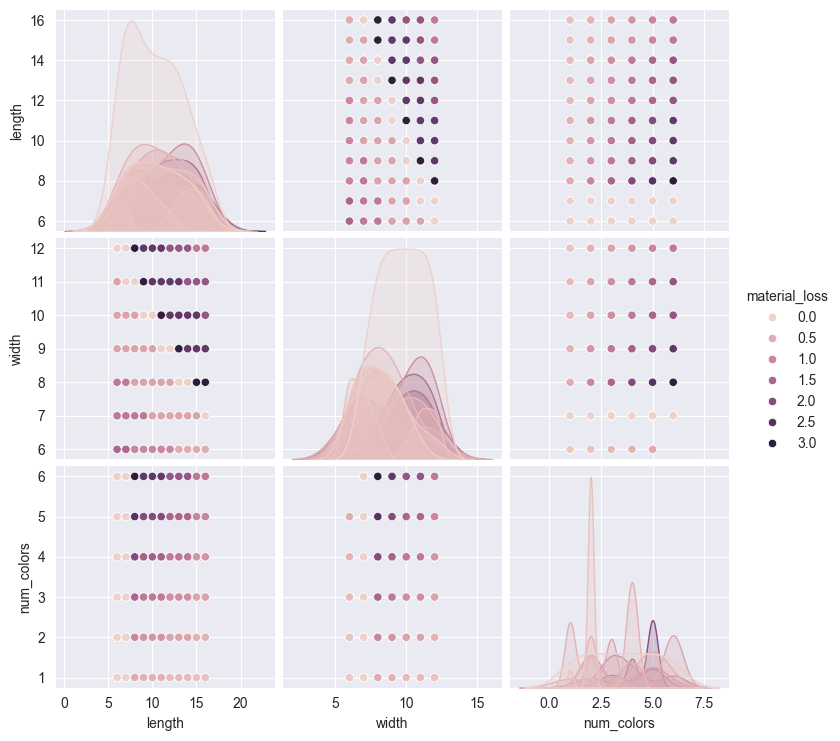

In [78]:
# Moving the material loss value back to original df for analysis
material_loss_columns = ['length', 'width', 'num_colors', 'material_loss']
df_build_stats['material_loss'] = df_price['material_loss']
sns.pairplot(data=df_build_stats[material_loss_columns], hue='material_loss');


#### Observations
- There seems to be an optimal set of values for length and width parameters that will minimize material loss.

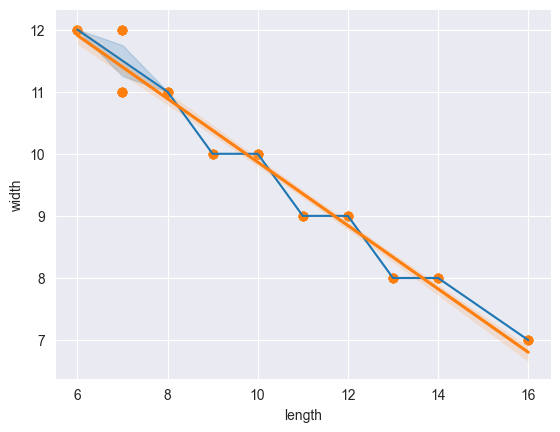

In [79]:
df_zero_loss = df_build_stats[df_build_stats['material_loss'] == 0]
sns.lineplot(data=df_zero_loss[material_loss_columns], x='length', y='width')
sns.regplot(data=df_zero_loss[material_loss_columns], x='length', y='width');
# We need to turn this regression line into an actual formula

#### Observations
- For the optimal material_loss values length + width = 18 or 20.
- If the customer only specifies one value in their request we can use this equation to calculate the other value.

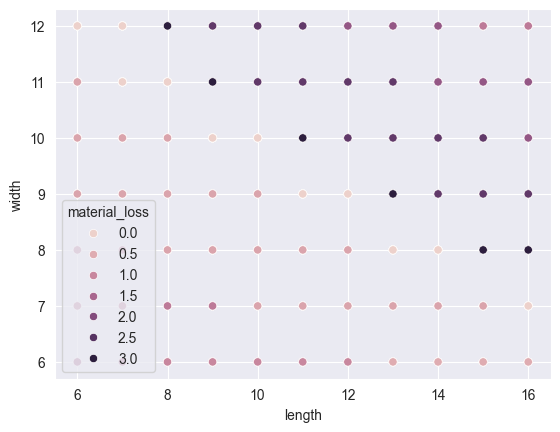

In [126]:
sns.scatterplot(data=df_build_stats[material_loss_columns], x='length', y='width', hue='material_loss');

#### Observations
- Orders slightly below these dimensions have less waste than orders slightly above them.

## Final Thoughts
- Based on the profit vs num_color plots the optimal price for our products is 40 per order and 10 extra per color.
- Orders with large number of colors are likely to have higher material loss, but also have a potential for higher profit.
- If we want to minimize material loss we should only offer products whose dimensions add up to less than 20.